In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import sys
from tensorflow.python.client import device_lib
import os
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
#     try:
#         tf.config.experimental.set_virtual_device_configuration(
#             gpus[0],
#             [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10000)])
#         tf.config.experimental.set_virtual_device_configuration(
#             gpus[1],
#             [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10000)])
#         tf.config.experimental.set_virtual_device_configuration(
#             gpus[2],
#             [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7000)])
#         tf.config.experimental.set_virtual_device_configuration(
#             gpus[3],
#             [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10000)])
#         logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#     except RuntimeError as e:
#         # Virtual devices must be set before GPUs have been initialized
#         print(e)

2023-01-06 12:35:42.318723: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


# Load Data

In [2]:
import os

directory = os.fsencode( "../../../../../datax/scratch/pma/reverse_search/train_large/")
count = 0
top = 20
data = []
for folder in os.listdir(directory):
    print(folder)
    for subfolder in os.listdir(directory+folder):
        back = os.fsencode( "/")
        for file in os.listdir(directory+folder+back+subfolder):
            file_directory = str(os.path.join(directory+folder+back+subfolder, file)).replace('b', '').replace("'","")
            if 'filtered.npy' in file_directory and count < top:
                temp = np.load(str(file_directory))
                print(temp.shape)
                data.append(temp)
                count += 1

b'HIP44295-23'
(191882, 16, 256)
(240087, 16, 256)
(233777, 16, 256)
(176479, 16, 256)
(282263, 16, 256)
(132926, 16, 256)
b'HIP63503-523'
(20190, 16, 256)
(12721, 16, 256)
(12694, 16, 256)
(53716, 16, 256)
(24144, 16, 256)
(13365, 16, 256)
b'AND_XI-2274'
b'HIP36393-1253'
(67084, 16, 256)
(154152, 16, 256)
(66705, 16, 256)
(91345, 16, 256)
(126293, 16, 256)
(121096, 16, 256)
b'HIP48477-589'
(54157, 16, 256)
(111678, 16, 256)


(2186754, 16, 256)


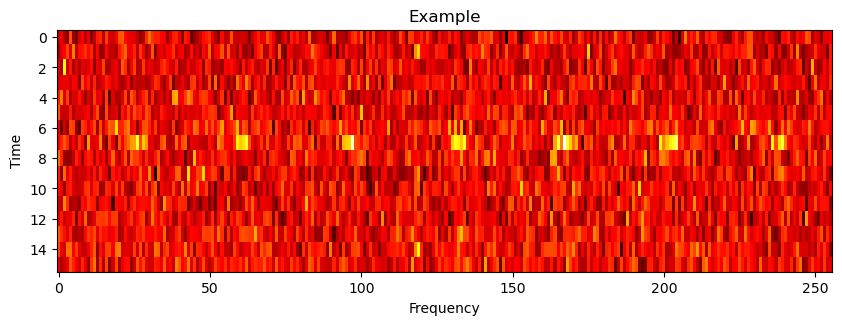

In [3]:
import numpy as np
data = np.vstack(data)
print(data.shape)

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(10,5))
plt.title("Example")
plt.xlabel("Frequency")
plt.ylabel("Time")
plt.imshow(data[1000, :, :], cmap='hot', aspect=5)

In [4]:
from tqdm import tqdm

def normalize(data):
    epsilon = 1
    min_val = data.min()
    data = data - min_val + epsilon
    new_data = np.log(data)
    min_val = data.min()
    max_val = data.max()
    final_data = (data - min_val) / (max_val - min_val)
    return final_data
    
def normalize_data(data):
    for i in tqdm(range(data.shape[0])):
        data[i,:,:] = normalize(data[i,:,:])
    return data

data = np.expand_dims(normalize_data(data), axis = -1)
print(data[0,:,:].max(), data[0,:,:].min())

100%|███████████████████████████████| 2186754/2186754 [04:54<00:00, 7430.35it/s]

1.0 0.0


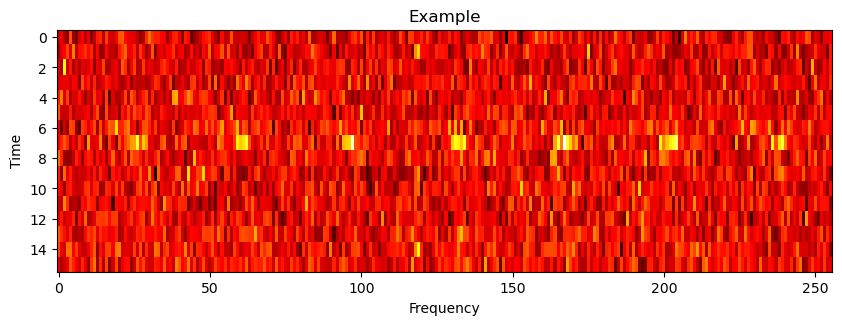

In [5]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(10,5))
plt.title("Example")
plt.xlabel("Frequency")
plt.ylabel("Time")
plt.imshow(data[1000, :, :], cmap='hot', aspect=5)

In [6]:
from sklearn.model_selection import train_test_split
import gc
X_train, X_test, y_train, y_test = train_test_split(data, data, test_size=0.33, random_state=42)
del data, y_train, y_test
gc.collect()

0

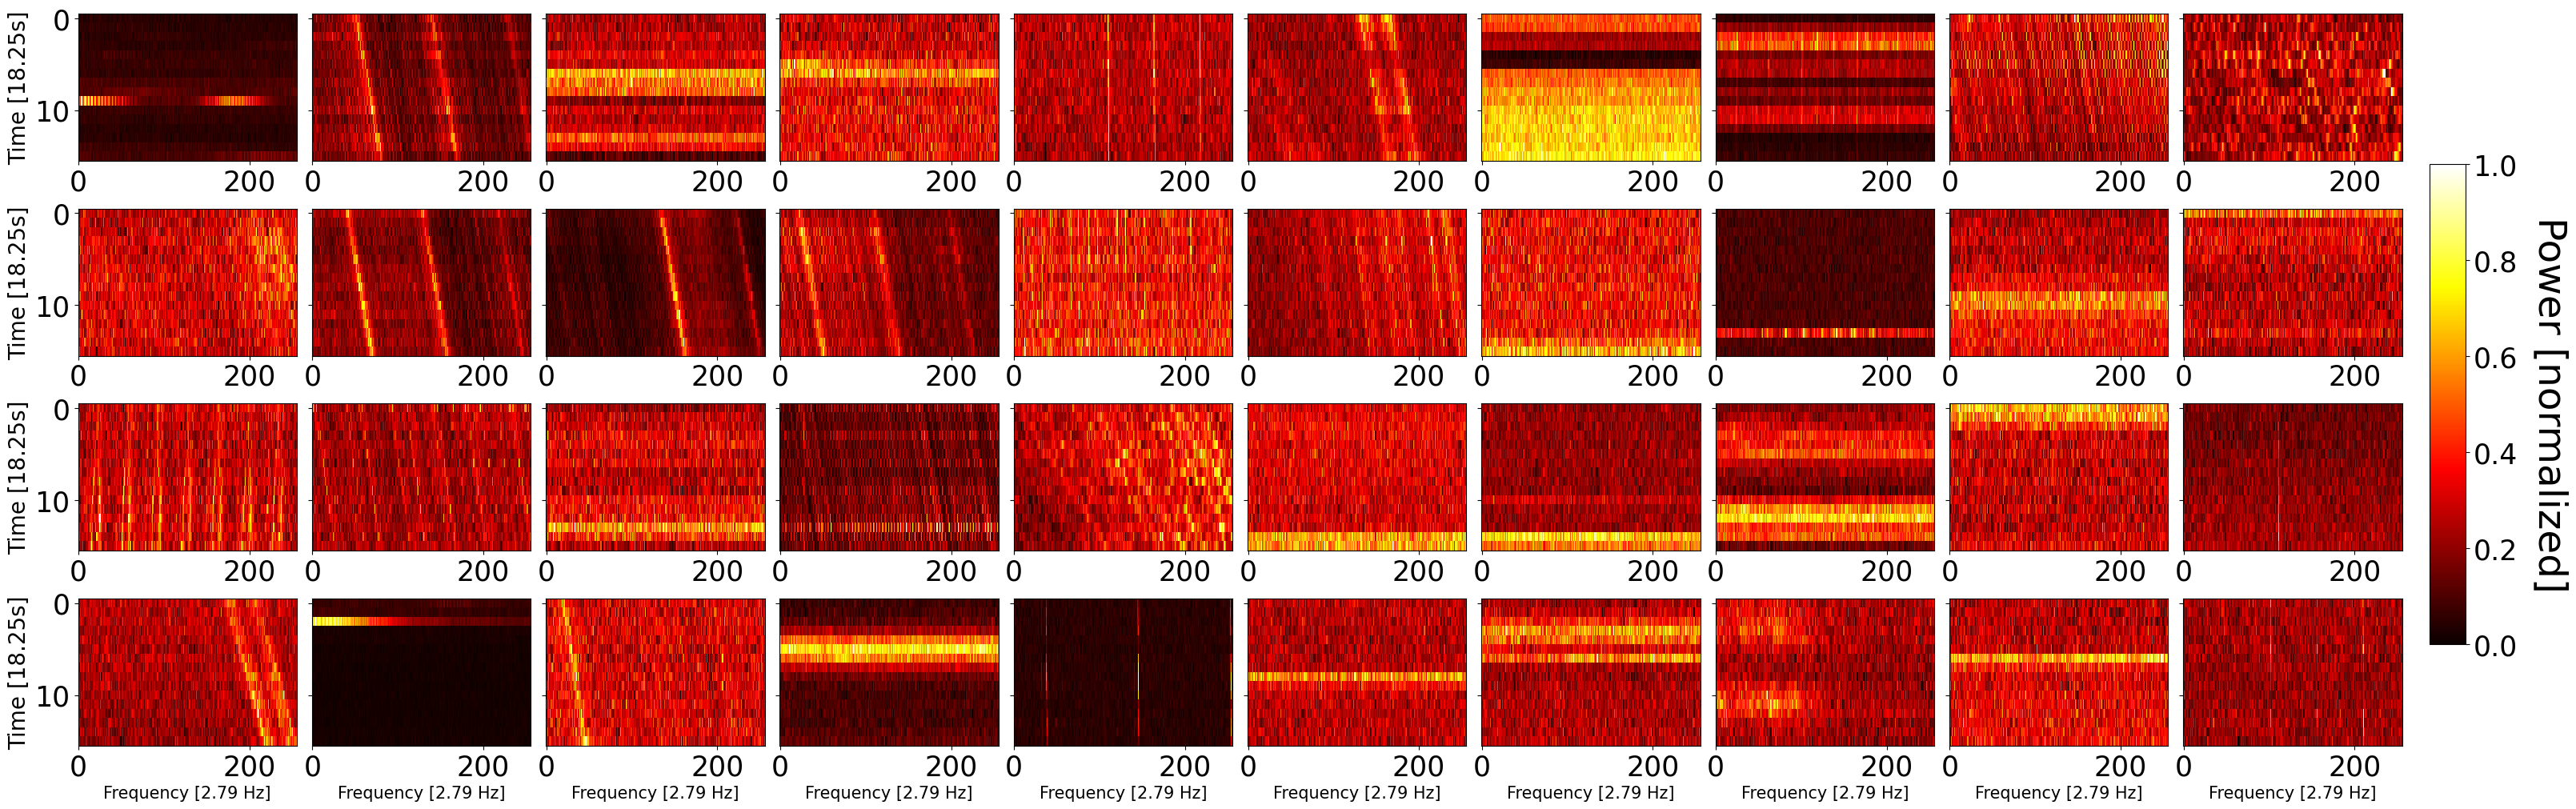

In [7]:
ind = np.random.randint(0, X_train.shape[0], size=(10, 10))
font_size = 25
plt.rcParams.update({'font.size': font_size})

f, ax = plt.subplots(4, 10, sharey=True, figsize=(30, 10), constrained_layout=True)

for j in range(10):
    for i in range(4):
        inde = ind[i, j]
        im = ax[i,j].imshow(X_train[inde,:,:,0], cmap='hot', interpolation='nearest', aspect="auto")
        if i == 3:
            ax[i,j].set_xlabel("Frequency [2.79 Hz]",  fontsize=font_size-10)  
        if j ==0:
            ax[i,j].set_ylabel("Time [18.25s]",  fontsize=font_size-5)  
            
        
cbaxes = f.add_axes([1.01, 0.2, 0.015, 0.6]) 
cbar = f.colorbar(im, cax=cbaxes)
cbar.ax.tick_params(labelsize=font_size)
f.text(1.06, 0.5, 'Power [normalized]', ha='center', va='center', rotation=270, 
       fontsize=font_size+10)

plt.savefig("plots/training_examples.pdf", format="pdf")


# Encoder Model

In [8]:
latent_dim = 6
time_samples = X_train.shape[1]
freq_sample =  X_train.shape[2]
encoder_inputs = keras.Input(shape=(time_samples, freq_sample, 1))
x = layers.Conv2D(16, 3, activation="relu", strides=1, padding="same")(encoder_inputs)
x = layers.MaxPool2D(pool_size=(1, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(x)
x = layers.MaxPool2D(pool_size=(1, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(x)
x = layers.MaxPool2D(pool_size=(1, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(x)
x = layers.MaxPool2D(pool_size=(1, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, 3, activation="relu", strides=1, padding="same")(x)
x = layers.MaxPool2D(pool_size=(1, 2))(x)
x = layers.BatchNormalization()(x)
x_shape = x.shape
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(16, activation="relu")(x)
x = layers.BatchNormalization()(x)
z = layers.Dense(latent_dim, name="latent", activation="linear")(x)
encoder = keras.Model(encoder_inputs, z, name="encoder")
encoder.summary()

2023-01-06 12:50:08.540593: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-06 12:50:08.759978: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-01-06 12:50:08.838007: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce GTX TITAN X computeCapability: 5.2
coreClock: 1.076GHz coreCount: 24 deviceMemorySize: 11.93GiB deviceMemoryBandwidth: 313.37GiB/s
2023-01-06 12:50:08.838620: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:03:00.0 name: NVIDIA GeForce GTX TITAN X computeCapability: 5.2
coreClock: 1.076GHz coreCount: 24 deviceMemorySize: 11.93GiB deviceMemoryBandwidth: 313.37GiB/s
2023-01-06 12:50:08.839415: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 2 with properties: 
pciBusID: 0000:83:0

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16, 256, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 256, 16)       160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 128, 16)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 128, 16)       64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 128, 32)       4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 64, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 64, 32)        128 

# Decoder Model

In [9]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(16, activation="relu")(latent_inputs)
x = layers.Dense(128, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(x_shape[1]* x_shape[2]* x_shape[3], activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Reshape((x_shape[1], x_shape[2], x_shape[3]))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.MaxPool2D(pool_size=(2, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.MaxPool2D(pool_size=(2, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.MaxPool2D(pool_size=(2, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.MaxPool2D(pool_size=(2, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)
x = layers.MaxPool2D(pool_size=(2, 1))(x)
x = layers.BatchNormalization()(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="linear", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                112       
_________________________________________________________________
dense_3 (Dense)              (None, 128)               2176      
_________________________________________________________________
batch_normalization_7 (Batch (None, 128)               512       
_________________________________________________________________
dense_4 (Dense)              (None, 8192)              1056768   
_________________________________________________________________
batch_normalization_8 (Batch (None, 8192)              32768     
_________________________________________________________________
reshape (Reshape)            (None, 16, 8, 64)         0   

In [10]:
def build_model(enocder, decoder):
    autoencoder = AE(encoder, decoder)
    autoencoder.compile(optimizer=keras.optimizers.Adam(lr=3e-4))
    return autoencoder

# Training Model

In [ ]:
from keras.callbacks import EarlyStopping
from AE import AE
from keras.callbacks import CSVLogger
es = EarlyStopping(monitor='val_test_reconstruction_loss', mode='min', verbose=1, patience=10)
csv_logger = CSVLogger('log.csv', append=True, separator=',')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./checkpoints_file',
    save_weights_only=True,
    monitor='val_test_loss',
    mode='min',
    save_best_only=True)

autoencoder = build_model(encoder, decoder)

history = autoencoder.fit(X_train[:,:,:,:], validation_data = (X_test[:20_000,:,:,:],X_test[:20_000,:,:,:]),
                  epochs=200, batch_size = 128, callbacks=[es,csv_logger, model_checkpoint_callback])

2023-01-06 12:50:32.572868: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 24004608000 exceeds 10% of free system memory.
2023-01-06 12:50:47.423270: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-01-06 12:50:47.443197: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2200070000 Hz


Epoch 1/200


2023-01-06 12:50:49.192692: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-01-06 12:50:50.016525: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


11447/11447 [==============================] - 812s 70ms/step - loss: 44.9363 - reconstruction_loss: 36.3148 - val_test_loss: 33.3321 - val_test_reconstruction_loss: 33.3321
Epoch 2/200
11447/11447 [==============================] - 796s 70ms/step - loss: 33.1448 - reconstruction_loss: 32.9750 - val_test_loss: 32.6302 - val_test_reconstruction_loss: 32.6302
Epoch 3/200
11447/11447 [==============================] - 796s 70ms/step - loss: 32.5253 - reconstruction_loss: 32.4124 - val_test_loss: 32.1571 - val_test_reconstruction_loss: 32.1571
Epoch 4/200
11447/11447 [==============================] - 796s 70ms/step - loss: 32.0801 - reconstruction_loss: 31.9764 - val_test_loss: 31.7709 - val_test_reconstruction_loss: 31.7709
Epoch 5/200
10970/11447 [===========================>..] - ETA: 32s - loss: 31.7317 - reconstruction_loss: 31.6797

In [ ]:
import pandas as pd
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(20,10))
plt.plot(history.history['reconstruction_loss'])
plt.plot(history.history['val_test_reconstruction_loss'])
plt.title('Model MSE Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Validation Loss'], loc='upper left')
# plt.yscale('log')
plt.grid()
plt.savefig("plots/training_loss.pdf", format='pdf')
plt.show()

training_history = {}
training_history['train'] = history.history['reconstruction_loss']
training_history['test'] = history.history['val_test_reconstruction_loss']
df = pd.DataFrame(training_history)
df.to_csv("plots/training_loss.csv")

In [ ]:
from datetime import datetime
now = datetime.now() # current date and time
date_time = now.strftime("%m/%d/%Y, %H:%M:%S")
idtag = date_time.replace(', ','-').replace('/','-').replace(':','-')
print(idtag)

autoencoder.save_weights("models/full-weights-"+idtag, save_format="tf")

In [ ]:
autoencoder.load_weights("models/full-weights-"+idtag)
autoencoder.compile(optimizer=keras.optimizers.Adam(lr = 1e-4), run_eagerly=True)

# Test Reconstruction

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
index = 12

beam_reconstruction = autoencoder.decoder.predict(autoencoder.encoder.predict(X_test[index:index+1,:,:,:]))
print(beam_reconstruction.shape)

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(10,5))
plt.title("Reconstruction of Observation")
plt.imshow(beam_reconstruction[0,:,:,0], cmap='hot', interpolation='nearest', aspect=3)
plt.ylabel("Time Bins [18.25s]")
plt.xlabel("Frequency Bins [2.79Hz]")
plt.savefig("plots/reconstruction.pdf", format='pdf')

In [ ]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(10,5))
plt.title("Real Observation")
plt.imshow(X_test[index,:,:,0], cmap='hot', interpolation='nearest', aspect=3)
plt.ylabel("Time Bins [18.25s]")
plt.xlabel("Frequency Bins [2.79Hz]")
plt.savefig("plots/real.pdf", format='pdf')

In [ ]:
ind = np.random.randint(20_000, X_test.shape[0], size=(10))
font_size = 80
plt.rcParams.update({'font.size': font_size})

f, ax = plt.subplots(2, 8, sharey=True, figsize=(100, 30), constrained_layout=True)

for j in range(8):
    inde = ind[j]
    beam_reconstruction = autoencoder.decoder.predict(autoencoder.encoder.predict(X_test[inde:inde+1,:,:,:]))
    im = ax[0,j].imshow(beam_reconstruction[0,:,:,0], cmap='hot',
                        interpolation='nearest', aspect="auto")
    ax[1,j].imshow(X_test[inde,:,:,0], cmap='hot', interpolation='nearest', aspect="auto")
    if j == 0:
        ax[1,j].text(-50, 7, 'Time [18.7s]', ha='center', va='center', rotation='vertical',  fontsize=font_size)
        ax[1,j].text(-100, 7, 'Real Obs', ha='center', va='center', rotation='vertical', 
                     fontsize=font_size+20)
        ax[0,j].text(-100, 7, 'Reconstruction', ha='center', va='center', rotation='vertical',  fontsize=font_size  +20)
        ax[0,j].text(-50, 7, 'Time [18.25s]', ha='center', va='center', rotation='vertical',  fontsize=font_size)
    ax[1,j].set_xlabel("Frequency [2.79 Hz]",  fontsize=font_size-5)  
    
cbaxes = f.add_axes([1.01, 0.2, 0.015, 0.6]) 
cbar = f.colorbar(im, cax=cbaxes)
cbar.ax.tick_params(labelsize=font_size)
f.text(1.06, 0.5, 'Power [normalized]', ha='center', va='center', rotation=270, 
       fontsize=font_size+10)

plt.savefig("plots/reconstruction_test.pdf", format="pdf")